In [1]:
import numpy as np
import pandas as pd
import pandasql as sql
import holidays
import pandas_profiling as prof
from itertools import chain
from statsmodels.tsa.arima_model import ARIMA
import datetime
import geopandas as gpd
import libpysal as sal
import pysal 
import multiprocessing as mp
from libpysal.weights import Queen, Rook, KNN
import esda as esda
from sklearn.model_selection import train_test_split
from shapely.geometry import Point, Polygon, LineString
import contextily as ctx
import pyproj
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import geobr
import geoplot
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify as mc
plt.style.use('classic')
%matplotlib inline
from splot.esda import moran_scatterplot
from sklearn.metrics import mean_absolute_error
np.random.seed(12345)
import os
os.chdir("C:\\Users\\Caio Serrano\\Google Drive\\4-MacBook Pro\\Py - Codes\\DataScienceGit\\DataScienceProjects\\Geospatial\\dataset")
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

C:\Anaconda3\envs\alpha\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Anaconda3\envs\alpha\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite ba

In [2]:
cust = pd.read_csv('../dataset/olist_customers_dataset.csv')
geo = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
ord_itens = pd.read_csv('../dataset/olist_order_items_dataset.csv')
ord_pymt = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
ord_rev = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
fact_ord = pd.read_csv('../dataset/olist_orders_dataset.csv')
prdts = pd.read_csv('../dataset/olist_products_dataset.csv')
seller = pd.read_csv('../dataset/olist_sellers_dataset.csv')

In [134]:
##geo_poly = geo.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state']).agg(list).apply(lambda x: tuple(chain.from_iterable(zip(x['geolocation_lng'], x['geolocation_lat']))), axis=1).reset_index(name='geometry')
geo_avg = sql.sqldf("""
                SELECT
                geolocation_zip_code_prefix geolocation_zip_code_prefix,
                geolocation_city geolocation_city,
                geolocation_state geolocation_state,
                AVG(geolocation_lat) geolocation_lat,
                AVG(geolocation_lng) geolocation_lng
                FROM geo f
                GROUP BY 1,2,3
                """)

geo_poly_sp = sql.sqldf("""
                SELECT
                *
                FROM
                (
                    SELECT
                    geolocation_zip_code_prefix geolocation_zip_code_prefix,
                    geolocation_city geolocation_city,
                    geolocation_state geolocation_state,
                    geolocation_lat geolocation_lat,
                    geolocation_lng geolocation_lng,
                    COUNT(CAST(geolocation_lat AS VARCHAR(1000)) + '-' + CAST(geolocation_lng AS VARCHAR(1000))) poly_check
                    FROM geo f
                    GROUP BY 1,2,3,4,5
                )
                WHERE poly_check >= 3
                AND geolocation_state = 'SP'
                """)

geo_gpds = gpd.GeoDataFrame(geo_avg, geometry = gpd.points_from_xy(geo_avg.geolocation_lng,geo_avg.geolocation_lat))
#geo_gpds['geometry'] = geo_gpds['geometry'].apply(lambda x: x.coords[0])
#geo_gpds = geo_gpds.groupby('geolocation_zip_code_prefix')['geometry'].apply(lambda x: Polygon(x.tolist())).reset_index()
#geo_gpds = gpd.GeoDataFrame(df, geometry = 'geometry')
#geo_gpds.plot(figsize=(20,10))
geo_gpds.to_csv('geolocation_zip_code.csv')

In [4]:
query = sql.sqldf("""
                SELECT
                f.order_id order_nr,
                f.*,
                it.*,
                prdts.*,
                s.*,
                c.*,
                p.*,
                r.*
                FROM fact_ord f
                LEFT JOIN ord_itens it ON f.order_id = it.order_id
                LEFT JOIN prdts prdts ON it.product_id = prdts.product_id
                LEFT JOIN seller s ON it.seller_id = s.seller_id
                LEFT JOIN cust c ON f.customer_id = c.customer_id
                LEFT JOIN ord_pymt p ON f.order_id = p.order_id
                LEFT JOIN ord_rev r ON f.order_id = r.order_id
                """)

orders = pd.DataFrame(query)

In [5]:
orders.drop(columns=['order_id'], inplace=True)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_purchase_year'] = orders['order_purchase_timestamp'].dt.year
orders['order_purchase_month'] = orders['order_purchase_timestamp'].dt.month
orders['order_purchase_day'] = orders['order_purchase_timestamp'].dt.day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].dt.hour
orders['order_purchase_minute'] = orders['order_purchase_timestamp'].dt.minute
orders['order_purchase_weekday'] = orders['order_purchase_timestamp'].dt.day_name()

orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_approved_at_year'] = orders['order_approved_at'].dt.year
orders['order_approved_at_month'] = orders['order_approved_at'].dt.month
orders['order_approved_at_day'] = orders['order_approved_at'].dt.day
orders['order_approved_at_hour'] = orders['order_approved_at'].dt.hour
orders['order_approved_at_minute'] = orders['order_approved_at'].dt.minute
orders['order_approved_at_weekday'] = orders['order_approved_at'].dt.day_name()

orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_carrier_date_year'] = orders['order_delivered_carrier_date'].dt.year
orders['order_delivered_carrier_date_month'] = orders['order_delivered_carrier_date'].dt.month
orders['order_delivered_carrier_date_day'] = orders['order_delivered_carrier_date'].dt.day
orders['order_delivered_carrier_date_hour'] = orders['order_delivered_carrier_date'].dt.hour
orders['order_delivered_carrier_date_minute'] = orders['order_delivered_carrier_date'].dt.minute
orders['order_delivered_carrier_date_weekday'] = orders['order_delivered_carrier_date'].dt.day_name()

orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_estimated_delivery_date_year'] = orders['order_estimated_delivery_date'].dt.year
orders['order_estimated_delivery_date_month'] = orders['order_estimated_delivery_date'].dt.month
orders['order_estimated_delivery_date_day'] = orders['order_estimated_delivery_date'].dt.day
orders['order_estimated_delivery_date_hour'] = orders['order_estimated_delivery_date'].dt.hour
orders['order_estimated_delivery_date_minute'] = orders['order_estimated_delivery_date'].dt.minute
orders['order_estimated_delivery_date_weekday'] = orders['order_estimated_delivery_date'].dt.day_name()

orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_delivered_customer_date_year'] = orders['order_delivered_customer_date'].dt.year
orders['order_delivered_customer_date_month'] = orders['order_delivered_customer_date'].dt.month
orders['order_delivered_customer_date_day'] = orders['order_delivered_customer_date'].dt.day
orders['order_delivered_customer_date_hour'] = orders['order_delivered_customer_date'].dt.hour
orders['order_delivered_customer_date_minute'] = orders['order_delivered_customer_date'].dt.minute
orders['order_delivered_customer_date_weekday'] = orders['order_delivered_customer_date'].dt.day_name()

orders['shipping_limit_date'] = pd.to_datetime(orders['shipping_limit_date'])
orders['shipping_limit_date_year'] = orders['shipping_limit_date'].dt.year
orders['shipping_limit_date_month'] = orders['shipping_limit_date'].dt.month
orders['shipping_limit_date_day'] = orders['shipping_limit_date'].dt.day
orders['shipping_limit_date_hour'] = orders['shipping_limit_date'].dt.hour
orders['shipping_limit_date_minute'] = orders['shipping_limit_date'].dt.minute
orders['shipping_limit_date_weekday'] = orders['shipping_limit_date'].dt.day_name()

orders['total_value'] = orders['price'] + orders['freight_value']

In [6]:
br_holidays = pd.DataFrame.from_dict(holidays.Brazil(years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_sp_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='SP',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_rj_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='RJ',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_mg_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='MG',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_sc_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='SC',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_pr_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='PR',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
br_rs_holidays = pd.DataFrame.from_dict(holidays.Brazil(state='RS',years=[2016,2017,2018]), orient='index').rename(columns={0: "DAY_NAME"}).rename_axis("date")
orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date
orders.set_index('order_purchase_date', inplace=False)

orders['order_purchase_timestamp_is_fed_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_holidays.index.to_list())
orders['order_purchase_timestamp_is_sp_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_purchase_timestamp_is_rj_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_purchase_timestamp_is_mg_holiday'] = orders['order_purchase_timestamp'].dt.date.isin(br_mg_holidays.index.to_list())

orders['order_approved_at_is_fed_holiday'] = orders['order_approved_at'].dt.date.isin(br_holidays.index.to_list())
orders['order_approved_at_is_sp_holiday'] = orders['order_approved_at'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_approved_at_is_rj_holiday'] = orders['order_approved_at'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_approved_at_is_mg_holiday'] = orders['order_approved_at'].dt.date.isin(br_mg_holidays.index.to_list())

orders['order_delivered_customer_date_is_fed_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_holidays.index.to_list())
orders['order_delivered_customer_date_is_sp_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_delivered_customer_date_is_rj_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_delivered_customer_date_is_mg_holiday'] = orders['order_delivered_customer_date'].dt.date.isin(br_mg_holidays.index.to_list())

orders['order_delivered_carrier_date_is_fed_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_holidays.index.to_list())
orders['order_delivered_carrier_date_is_sp_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_sp_holidays.index.to_list())
orders['order_delivered_carrier_date_is_rj_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_rj_holidays.index.to_list())
orders['order_delivered_carrier_date_is_mg_holiday'] = orders['order_delivered_carrier_date'].dt.date.isin(br_mg_holidays.index.to_list())

In [124]:
orders['order_status'].drop_duplicates()
orders_approved = orders[(orders['order_status'] == 'approved') 
                         | (orders['order_status'] == 'delivered') 
                         & (orders_approved['product_category_name'].isnull() == False) 
                         & (orders_approved['customer_state'] == 'SP')]

In [125]:
orders_customers_geo = pd.merge(orders_approved, geo_gpds,  how='inner' ,left_on=['customer_zip_code_prefix','customer_city','customer_state'], right_on =['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])
orders_seller_geo = pd.merge(orders_approved, geo_gpds,  how='inner' ,left_on=['seller_zip_code_prefix','seller_city','seller_state'], right_on=['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])

orders_customers_geo = gpd.GeoDataFrame(orders_customers_geo, crs=4674 , geometry = gpd.points_from_xy(orders_customers_geo.geolocation_lng, orders_customers_geo.geolocation_lat))  
orders_seller_geo = gpd.GeoDataFrame(orders_seller_geo, crs=4674 , geometry = gpd.points_from_xy(orders_seller_geo.geolocation_lng, orders_seller_geo.geolocation_lat))  

In [126]:
dist_orders = pd.merge(
    orders_customers_geo[['order_nr',
                          'customer_id',
                          'product_category_name',
                          'customer_zip_code_prefix',
                          'customer_city',
                          'customer_state',
                          'geolocation_lat',
                          'geolocation_lng',
                          'price',
                          'freight_value',
                          'total_value',
                          'geometry']].rename(columns={"geolocation_lat": "geolocation_lat_cust", "geolocation_lng": "geolocation_lng_cust", "geometry": "geometry_cust"}),
    orders_seller_geo[['order_nr',
                       'seller_id',
                       'seller_zip_code_prefix',
                       'seller_city',
                       'seller_state',
                       'geolocation_lat',
                       'geolocation_lng',
                       'geometry']].rename(columns={"geolocation_lat": "geolocation_lat_seller", "geolocation_lng": "geolocation_lng_seller", "geometry": "geometry_seller"}),
    how = 'inner',
    left_on=['order_nr'],
    right_on=['order_nr']
)
dist_orders = dist_orders.loc[:,~dist_orders.columns.duplicated()]

In [ ]:
def distance(s_lat, s_lng, e_lat, e_lng):
    "Haversine formula hav(theta)=sin(pwr)2(theta/2)"
    # approximate radius of earth in km
    R = 6373.0
    s_lat = s_lat*np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat) * np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2
    return 2 * R * np.arcsin(np.sqrt(d)) 
dist_orders['distance_ori'] = distance(dist_orders['geolocation_lat_cust'], dist_orders['geolocation_lng_cust'], dist_orders['geolocation_lat_seller'], dist_orders['geolocation_lng_seller'])
df_aux_search = dist_orders
dist_orders['distance_ori'] = distance(dist_orders['geolocation_lat_cust'],dist_orders['geolocation_lng_cust'],dist_orders['geolocation_lat_seller'],dist_orders['geolocation_lng_seller'])
dist_orders['best_seller_id'] = ''
dist_orders['best_seller_lat'] = 0.0
dist_orders['best_seller_lng'] = 0.0
dist_orders['best_seller_distance'] = -1
dist_orders['best_seller_freight'] = -1
dist_orders['best_seller_price'] = -1
dist_orders['isTheBestSeller'] = 0
dist_orders['isTheBestPrice'] = 0
for index, row in dist_orders.iterrows():
    #print("Listing index : " + str(index))
    product_category_name = row['product_category_name']
    lat = row['geolocation_lat_cust']
    lng = row['geolocation_lng_cust']
    #print(product_category_name)
    #print(str(lat) + ' ' + str(lng))
    sellers_df = df_aux_search[['product_category_name','seller_id','geolocation_lat_seller','geolocation_lng_seller','freight_value','price']][df_aux_search.product_category_name == product_category_name].drop_duplicates()
    sellers_df['distance_from_seller'] = distance(sellers_df['geolocation_lat_seller'], sellers_df['geolocation_lng_seller'], lat, lng)
    result = sellers_df[sellers_df['distance_from_seller'] == sellers_df['distance_from_seller'].min()].head(1)
    result.reset_index(inplace=True)
    #print(result.head(1))
    dist_orders.loc[index,'best_seller_id'] = result.loc[0,'seller_id']
    dist_orders.loc[index,'best_seller_lat'] = result.loc[0,'geolocation_lat_seller']
    dist_orders.loc[index,'best_seller_lng'] = result.loc[0,'geolocation_lng_seller']
    dist_orders.loc[index,'best_seller_distance'] = result.loc[0,'distance_from_seller']
    dist_orders.loc[index,'best_seller_freight'] = result.loc[0,'freight_value']
    dist_orders.loc[index,'best_seller_price'] = result.loc[0,'price']
    if row['distance_ori'] <= row['best_seller_distance']:
        dist_orders.loc[index, 'isTheBestSeller'] = 1
    else:
        dist_orders.loc[index, 'isTheBestSeller'] = 0
    local = dist_orders.loc[index,'freight_value'] + dist_orders.loc[index,'price']
    best = result.loc[0,'freight_value'] + result.loc[0,'price']
    if local <= best:
        dist_orders.loc[index, 'isTheBestPrice'] = 1
    else:
        dist_orders.loc[index, 'isTheBestPrice'] = 0

In [ ]:
dist_orders

In [ ]:
ord_mean = pd.DataFrame(orders_customers_geo.groupby(['geolocation_lng','geolocation_lat'])['freight_value'].mean()).reset_index()
ord_mean = gpd.GeoDataFrame(ord_mean, crs=4674, geometry=gpd.points_from_xy(ord_mean.geolocation_lng,ord_mean.geolocation_lat))

ord_count = pd.DataFrame(orders_customers_geo.groupby(['geolocation_lng','geolocation_lat'])['order_nr'].nunique()).reset_index()
ord_count = gpd.GeoDataFrame(ord_count, crs=4674, geometry=gpd.points_from_xy(ord_count.geolocation_lng,ord_count.geolocation_lat))

In [ ]:
ord_mean['freight_value'].fillna(0, inplace=True)
y_freight = ord_mean['freight_value'].values
queen_freight = Queen.from_dataframe(ord_mean)
queen_freight.transform = 'r'
ax = ord_mean.plot(figsize=(12,10))
f,ax = queen_freight.plot(ord_mean, ax=ax)

In [ ]:
ord_count['order_nr'].fillna(0, inplace=True)
y_order_count = ord_count['order_nr'].values
queen_order_count = Queen.from_dataframe(ord_count)
queen_order_count.transform = 'r'
ax = ord_count.plot(figsize=(12,10))
f,ax = queen_order_count.plot(ord_count, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax = ord_mean.plot(column='freight_value', scheme='Quantiles', k=5, cmap='seismic', legend=True, ax=ax)
plt.title("Spatial Lag Mean freight_value")
plt.plot()

ylag_freight = sal.weights.lag_spatial(queen_freight,y_freight)
ylag_freight_q5 = mc.Quantiles(ylag_freight, k=5)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_mean.assign(freight_value=ylag_freight_q5.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k5")
plt.plot()
ylag_freight_q10 = mc.Quantiles(ylag_freight, k=10)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_mean.assign(freight_value=ylag_freight_q10.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k10")
plt.plot()
ylag_freight_q15 = mc.Quantiles(ylag_freight, k=15)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_mean.assign(freight_value=ylag_freight_q15.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k15")
plt.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax = ord_count.plot(column='order_nr', scheme='Quantiles', k=5, cmap='seismic', legend=True, ax=ax)

ylag_order_count = sal.weights.lag_spatial(queen_order_count,y_order_count)
ylag_order_count_q5 = mc.Quantiles(ylag_order_count, k=5)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_count.assign(order_nr=ylag_order_count_q5.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k5")
plt.plot()
ylag_order_count_q10 = mc.Quantiles(ylag_order_count, k=10)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_count.assign(order_nr=ylag_order_count_q10.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k10")
plt.plot()
ylag_order_count_q15 = mc.Quantiles(ylag_order_count, k=15)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_count.assign(order_nr=ylag_order_count_q15.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k15")
plt.plot()

In [ ]:
count = ord_mean['freight_value'].values
b, a = np.polyfit(count, ylag_freight, 1)
f, ax = plt.subplots(1, figsize=(9, 9), edgecolor='black')
mi = esda.moran.Moran(y_freight,queen_freight)
plt.plot(count, ylag_freight, '.', color='blue')
plt.vlines(count.mean(), ylag_freight.min(), ylag_freight.max(), linestyle='--')
plt.hlines(ylag_freight.mean(), count.min(), count.max(), linestyle='--')
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot MI: %1.3f' % (mi.I))
plt.ylabel('Spatial Lag of freight_value')
plt.xlabel('freight_value')
plt.show()

In [ ]:
count = ord_count['order_nr'].values
b, a = np.polyfit(count, ylag_order_count, 1)
f, ax = plt.subplots(1, figsize=(12, 10), edgecolor='black', )
mi = esda.moran.Moran(y_order_count,queen_order_count)
plt.plot(count, ylag_order_count, '.', color='blue')
plt.vlines(count.mean(), ylag_order_count.min(), ylag_order_count.max(), linestyle='--')
plt.hlines(ylag_order_count.mean(), count.min(), count.max(), linestyle='--')
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot MI: %1.3f' % (mi.I))
plt.ylabel('Spatial Lag of ord_count')
plt.xlabel('ord_count')
plt.show()

In [ ]:
sns.lineplot(x="order_purchase_date",
             y="total_value", 
             data=pd.DataFrame(orders_customers_geo.groupby('order_purchase_date')['total_value'].sum()))

In [ ]:
orders_gwr = orders_customers_geo[['price','seller_city','seller_state','product_width_cm','product_height_cm','product_length_cm','product_weight_g','freight_value','geolocation_lng','geolocation_lat']]
orders_gwr['freight_value'].fillna(0, inplace=True)
orders_gwr['price'].fillna(orders_gwr['price'].mean(), inplace=True)
orders_gwr['freight_value'].fillna(orders_gwr['freight_value'].mean(), inplace=True)
orders_gwr['product_width_cm'].fillna(orders_gwr['product_width_cm'].mean(), inplace=True)
orders_gwr['product_length_cm'].fillna(orders_gwr['product_length_cm'].mean(), inplace=True)
orders_gwr['product_weight_g'].fillna(orders_gwr['product_weight_g'].mean(), inplace=True)
orders_gwr['product_height_cm'].fillna(orders_gwr['product_height_cm'].mean(), inplace=True)
orders_gwr['seller_city'].fillna('EMPTY', inplace=True)
orders_gwr['seller_state'].fillna('EMPTY', inplace=True)


dummies_seller_state = pd.get_dummies(orders_gwr['seller_state']).rename(columns=lambda x: 'seller_state_' + str(x))
dummies_seller_city = pd.get_dummies(orders_gwr['seller_city']).rename(columns=lambda x: 'seller_city_' + str(x))

#orders_gwr = pd.concat([orders_gwr, dummies_product_category_name], axis=1)
orders_gwr = pd.concat([orders_gwr, dummies_seller_state], axis=1)
#orders_gwr = pd.concat([orders_gwr, dummies_seller_city], axis=1)
orders_gwr.drop(['seller_state','seller_city'], inplace=True, axis=1)

orders_gwr.columns.tolist()

In [ ]:
orders_gwr = pd.DataFrame(orders_gwr.groupby(['geolocation_lng','geolocation_lat'])['price',
                                                                                    'product_width_cm',
                                                                                    'product_height_cm',
                                                                                    'product_length_cm',
                                                                                    'product_weight_g',
                                                                                    'freight_value'].median()).reset_index()
orders_gwr = gpd.GeoDataFrame(orders_gwr, crs=4674 , geometry=gpd.points_from_xy(orders_gwr.geolocation_lng,orders_gwr.geolocation_lat))
y = pd.DataFrame(orders_gwr['freight_value'].values.reshape((-1,1)))
X = pd.DataFrame(orders_gwr[['price','product_width_cm','product_height_cm','product_length_cm','product_weight_g']])
x_coord = orders_gwr['geolocation_lng']
y_coord = orders_gwr['geolocation_lat']
coords = pd.DataFrame(list(zip(x_coord,y_coord)))
split = round(X.shape[0] * 0.70)

orders_sar_train = orders_gwr.iloc[:split,]
y_train = y.iloc[:split,]
X_train = X.iloc[:split,]
coords_train = coords.iloc[:split,]

orders_sar_test = orders_gwr.iloc[split:,]
y_test = y.iloc[split:,]
X_test = X.iloc[split:,]
coords_test = coords.iloc[split:,]

w = sal.weights.Queen.from_dataframe(orders_sar_train)
w.transform = 'R'
#model_sar = pysal.model.spreg.OLS(y_train.values, X_train.values, w=w, nonspat_diag=False, moran=True, white_test=True, name_x=X_train.columns.tolist(), name_y='freight_value', name_w='Queen')
model_lag = pysal.model.spreg.ML_Lag(y_train.values, X_train.values, w=w,   name_x=X_train.columns.tolist(), name_y='freight_value', name_w='Queen')
#mi = pysal.explore.esda.Moran(model_sar.u, w, two_tailed=False)
#print(model_sar.summary)
#print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm]))

mi = pysal.explore.esda.Moran(model_lag.u, w, two_tailed=False)
print(model_lag.summary)
print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm]))

In [ ]:
%%time
n_proc = 8 #Eight processors
pool = mp.Pool(n_proc) 

gwr_selector = pysal.model.mgwr.sel_bw.Sel_BW(coords_train, y_train.values, X_train.values)
gwr_bw = gwr_selector.search(pool=pool)
print("== GWR =====================")
print(gwr_bw)
print("============================")
GWR_model = pysal.model.mgwr.gwr.GWR(coords_train, y_train.values, X_train.values, gwr_bw, spherical=True).fit(pool=pool)
scale = GWR_model.scale
residuals = GWR_model.resid_response
print(GWR_model.summary())
print("============================")

pool.close() 
pool.join()

In [ ]:
pred_results = GWR_model.model.predict(coords_test.values, np.array(X_test, dtype='float32'), scale, residuals)
print(pred_results.predictions)
print(y_test.values)

In [132]:
pred_results = GWR_model.model.predict(coords_test.values, np.array(X_test, dtype='float32'), scale, residuals)
print(pred_results.predictions)
print(y_test.values)

In [133]:
dist_orders

,order_nr,customer_id,product_category_name,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_cust,geolocation_lng_cust,price,freight_value,total_value,geometry_cust,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_seller,geolocation_lng_seller,geometry_seller,distance_ori,best_seller_id,best_seller_lat,best_seller_lng,best_seller_distance,best_seller_freight,best_seller_price,isTheBestSeller,isTheBestPrice
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,utilidades_domesticas,3149,sao paulo,SP,-23.576818,-46.587181,29.99,8.72,38.71,POINT (-46.58718 -23.57682),3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP,-23.680705,-46.444323,POINT (-46.44432 -23.68070),18.586392,c6a7539d424a8402232c2228d7a03c5e,-23.568887,-46.571668,1.810894,43.07,40.50,0,1
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,utilidades_domesticas,3149,sao paulo,SP,-23.576818,-46.587181,29.99,8.72,38.71,POINT (-46.58718 -23.57682),3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP,-23.680705,-46.444323,POINT (-46.44432 -23.68070),18.586392,c6a7539d424a8402232c2228d7a03c5e,-23.568887,-46.571668,1.810894,43.07,40.50,0,1
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,utilidades_domesticas,3149,sao paulo,SP,-23.576818,-46.587181,29.99,8.72,38.71,POINT (-46.58718 -23.57682),3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP,-23.680705,-46.444323,POINT (-46.44432 -23.68070),18.586392,c6a7539d424a8402232c2228d7a03c5e,-23.568887,-46.571668,1.810894,43.07,40.50,0,1
3,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,utilidades_domesticas,3149,sao paulo,SP,-23.576818,-46.587181,29.99,8.72,38.71,POINT (-46.58718 -23.57682),3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP,-23.680705,-46.444323,POINT (-46.44432 -23.68070),18.586392,c6a7539d424a8402232c2228d7a03c5e,-23.568887,-46.571668,1.810894,43.07,40.50,0,1
4,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,utilidades_domesticas,3149,sao paulo,SP,-23.576818,-46.587181,29.99,8.72,38.71,POINT (-46.58718 -23.57682),3504c0cb71d7fa48d967e0e4c94d59d9,9350.0,maua,SP,-23.680705,-46.444323,POINT (-46.44432 -23.68070),18.586392,c6a7539d424a8402232c2228d7a03c5e,-23.568887,-46.571668,1.810894,43.07,40.50,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82503,c74540b0f084f6eef5649cac6541c6cb,66fe4d66419f0c7d08b03b2814aeb9ec,utilidades_domesticas,1235,sao paulo,SP,-23.536814,-46.664678,42.90,16.32,59.22,POINT (-46.66468 -23.53681),276677b5d08786d5dce7c2149dcce48b,31730.0,belo horizonte,MG,-19.836058,-43.945382,POINT (-43.94538 -19.83606),498.391548,e5a38146df062edaf55c38afa99e42dc,-23.536181,-46.661617,0.320005,9.44,89.18,0,1
82504,c74540b0f084f6eef5649cac6541c6cb,66fe4d66419f0c7d08b03b2814aeb9ec,utilidades_domesticas,1235,sao paulo,SP,-23.536814,-46.664678,42.90,16.32,59.22,POINT (-46.66468 -23.53681),276677b5d08786d5dce7c2149dcce48b,31730.0,belo horizonte,MG,-19.836058,-43.945382,POINT (-43.94538 -19.83606),498.391548,e5a38146df062edaf55c38afa99e42dc,-23.536181,-46.661617,0.320005,9.44,89.18,0,1
82505,b9fce2067f47956396b6782d9bf146ca,9eb9bec6a91d6b82b4a39e49276f1e8f,moveis_decoracao,7860,franco da rocha,SP,-23.319686,-46.718579,50.90,12.70,63.60,POINT (-46.71858 -23.31969),cca3071e3e9bb7d12640c9fbe2301306,14940.0,ibitinga,SP,-21.757321,-48.829744,POINT (-48.82974 -21.75732),277.913176,93b9a99027bd8bd6af682aff18dd19bf,-23.330293,-46.597437,12.429550,8.40,34.00,0,0
82506,25877da244143a5dd6a686b8090c98e1,cb83a5aafc687c5f72d6f28b4d7a73e7,cool_stuff,3905,sao paulo,SP,-23.579906,-46.515115,148.00,13.17,161.17,POINT (-46.51511 -23.57991),e9bc59e7b60fc3063eb2290deda4cced,87083.0,maringa,PR,-23.387789,-51.955007,POINT (-51.95501 -23.38779),555.338940,b2ba3715d723d245138f291a6fe42594,-23.569199,-46.522178,1.391749,11.73,59.90,0,0


In [8]:
ord_mean = pd.DataFrame(orders_customers_geo.groupby(['geolocation_lng','geolocation_lat'])['freight_value'].mean()).reset_index()
ord_mean = gpd.GeoDataFrame(ord_mean, crs=4674, geometry=gpd.points_from_xy(ord_mean.geolocation_lng,ord_mean.geolocation_lat))

ord_count = pd.DataFrame(orders_customers_geo.groupby(['geolocation_lng','geolocation_lat'])['order_nr'].nunique()).reset_index()
ord_count = gpd.GeoDataFrame(ord_count, crs=4674, geometry=gpd.points_from_xy(ord_count.geolocation_lng,ord_count.geolocation_lat))

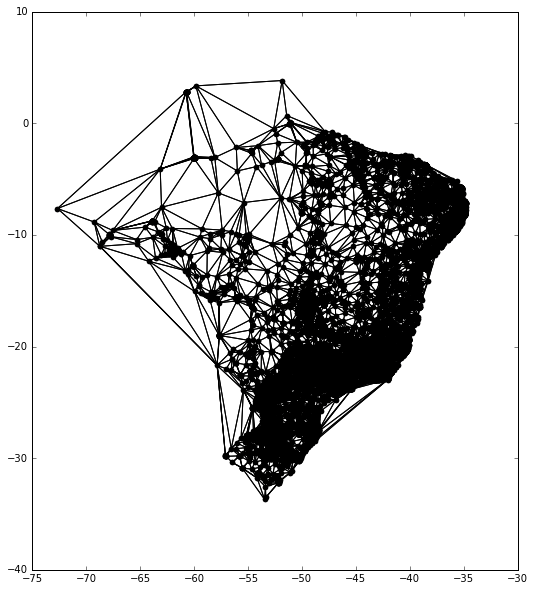

In [9]:
ord_mean['freight_value'].fillna(0, inplace=True)
y_freight = ord_mean['freight_value'].values
queen_freight = Queen.from_dataframe(ord_mean)
queen_freight.transform = 'r'
ax = ord_mean.plot(figsize=(12,10))
f,ax = queen_freight.plot(ord_mean, ax=ax)

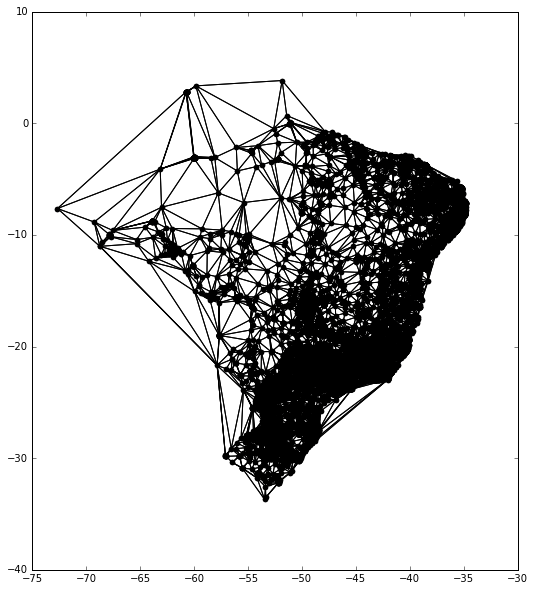

In [10]:
ord_count['order_nr'].fillna(0, inplace=True)
y_order_count = ord_count['order_nr'].values
queen_order_count = Queen.from_dataframe(ord_count)
queen_order_count.transform = 'r'
ax = ord_count.plot(figsize=(12,10))
f,ax = queen_order_count.plot(ord_count, ax=ax)

[]

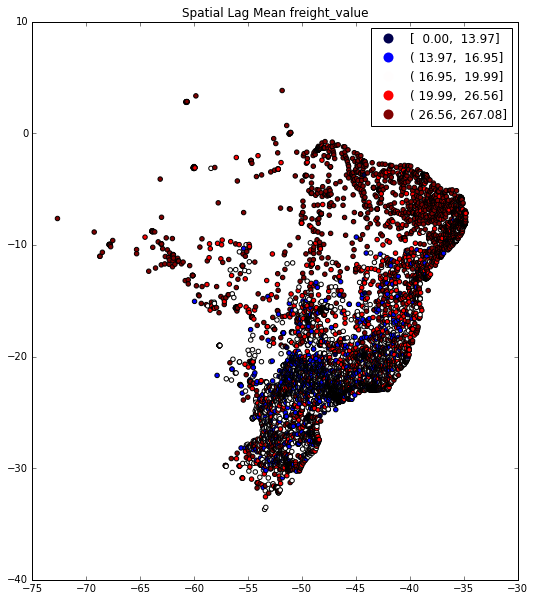

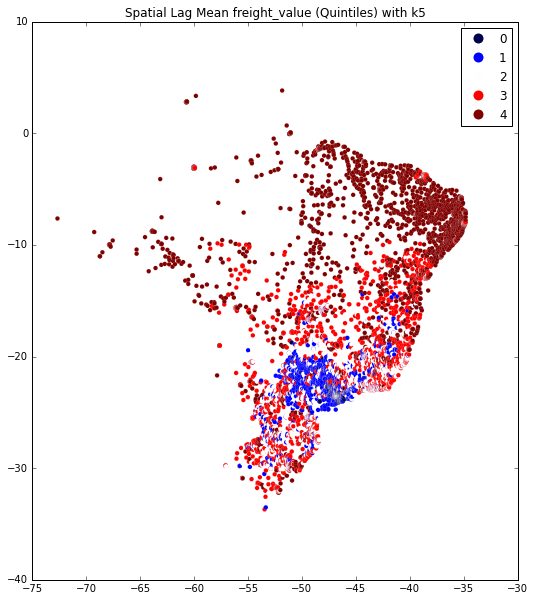

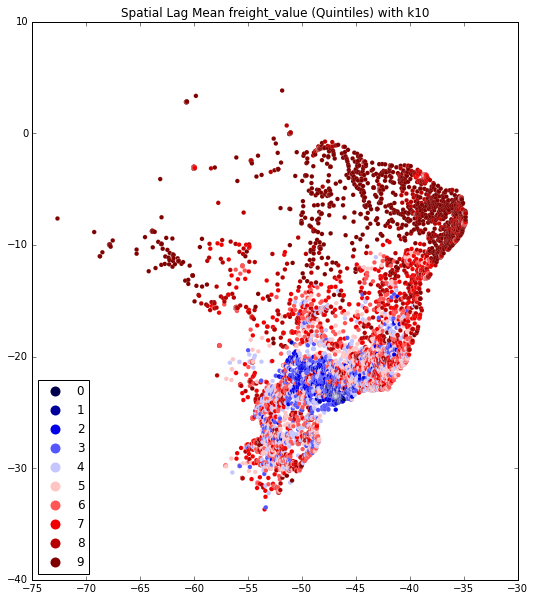

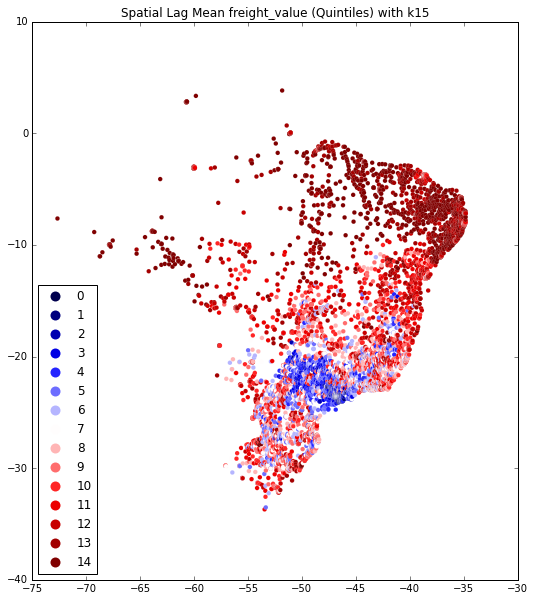

In [11]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax = ord_mean.plot(column='freight_value', scheme='Quantiles', k=5, cmap='seismic', legend=True, ax=ax)
plt.title("Spatial Lag Mean freight_value")
plt.plot()

ylag_freight = sal.weights.lag_spatial(queen_freight,y_freight)
ylag_freight_q5 = mc.Quantiles(ylag_freight, k=5)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_mean.assign(freight_value=ylag_freight_q5.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k5")
plt.plot()
ylag_freight_q10 = mc.Quantiles(ylag_freight, k=10)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_mean.assign(freight_value=ylag_freight_q10.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k10")
plt.plot()
ylag_freight_q15 = mc.Quantiles(ylag_freight, k=15)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_mean.assign(freight_value=ylag_freight_q15.yb).plot(column='freight_value', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean freight_value (Quintiles) with k15")
plt.plot()

[]

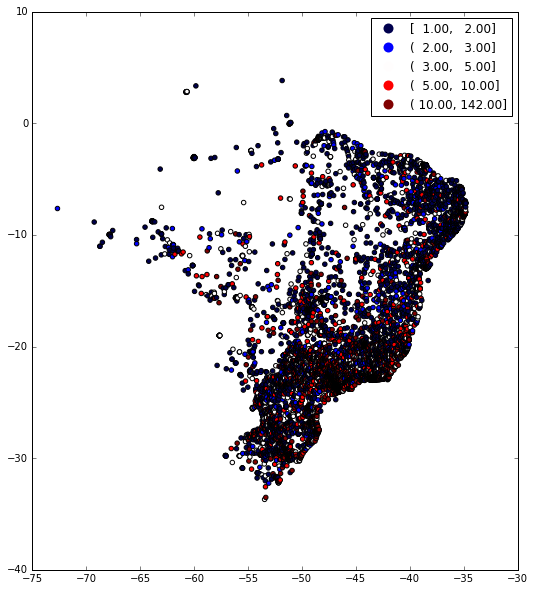

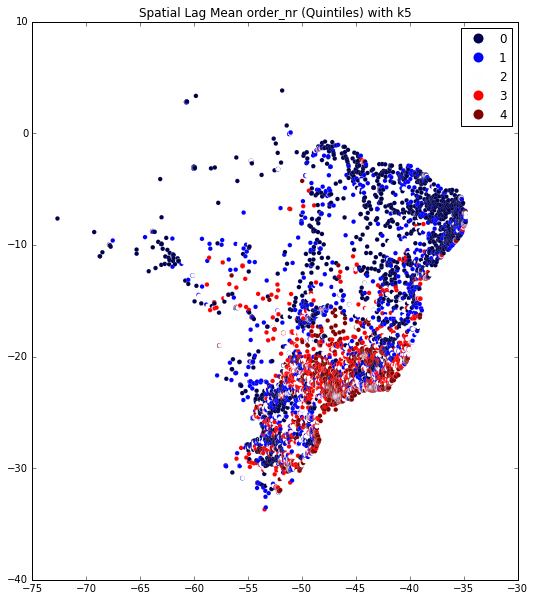

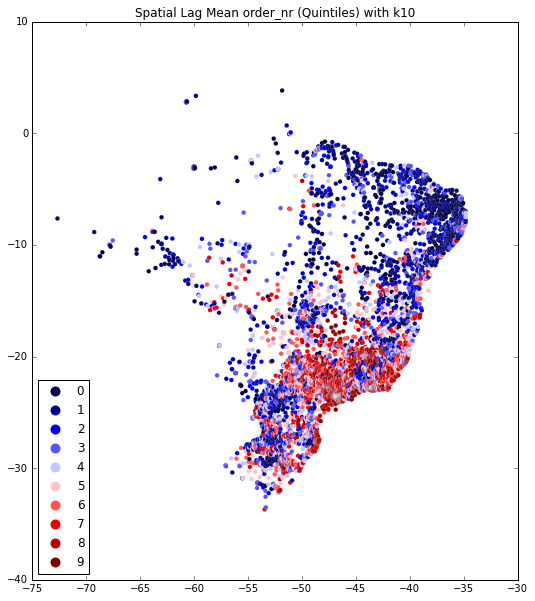

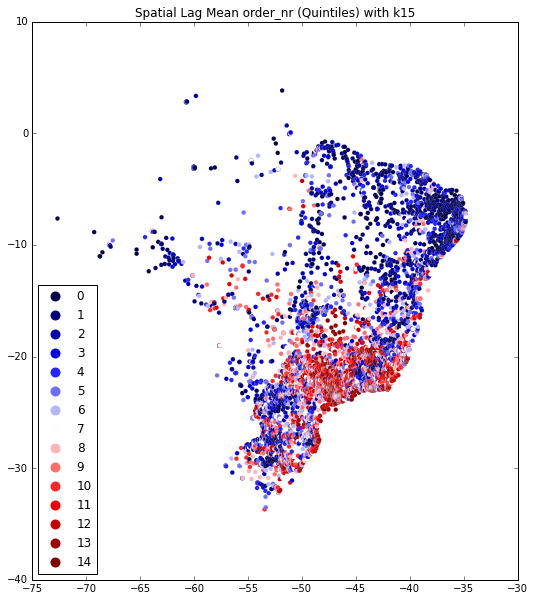

In [12]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax = ord_count.plot(column='order_nr', scheme='Quantiles', k=5, cmap='seismic', legend=True, ax=ax)

ylag_order_count = sal.weights.lag_spatial(queen_order_count,y_order_count)
ylag_order_count_q5 = mc.Quantiles(ylag_order_count, k=5)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_count.assign(order_nr=ylag_order_count_q5.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k5")
plt.plot()
ylag_order_count_q10 = mc.Quantiles(ylag_order_count, k=10)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_count.assign(order_nr=ylag_order_count_q10.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k10")
plt.plot()
ylag_order_count_q15 = mc.Quantiles(ylag_order_count, k=15)
f, ax = plt.subplots(1, figsize=(12, 10))
ord_count.assign(order_nr=ylag_order_count_q15.yb).plot(column='order_nr', categorical=True, \
        k=5, cmap='seismic', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
#ctx.add_basemap(ax)
plt.title("Spatial Lag Mean order_nr (Quintiles) with k15")
plt.plot()

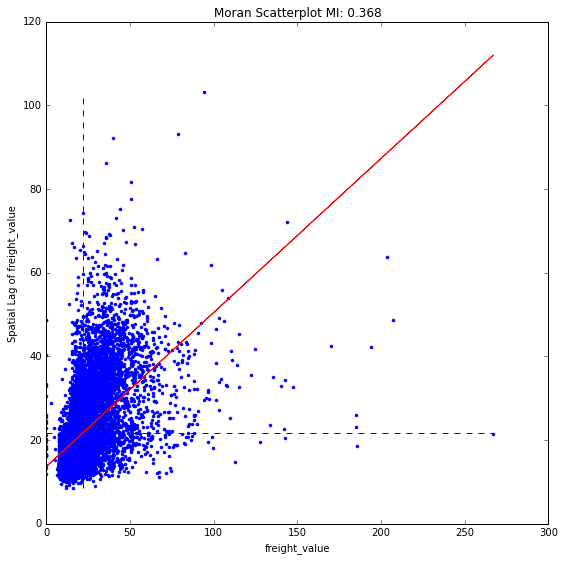

In [13]:
count = ord_mean['freight_value'].values
b, a = np.polyfit(count, ylag_freight, 1)
f, ax = plt.subplots(1, figsize=(9, 9), edgecolor='black')
mi = esda.moran.Moran(y_freight,queen_freight)
plt.plot(count, ylag_freight, '.', color='blue')
plt.vlines(count.mean(), ylag_freight.min(), ylag_freight.max(), linestyle='--')
plt.hlines(ylag_freight.mean(), count.min(), count.max(), linestyle='--')
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot MI: %1.3f' % (mi.I))
plt.ylabel('Spatial Lag of freight_value')
plt.xlabel('freight_value')
plt.show()

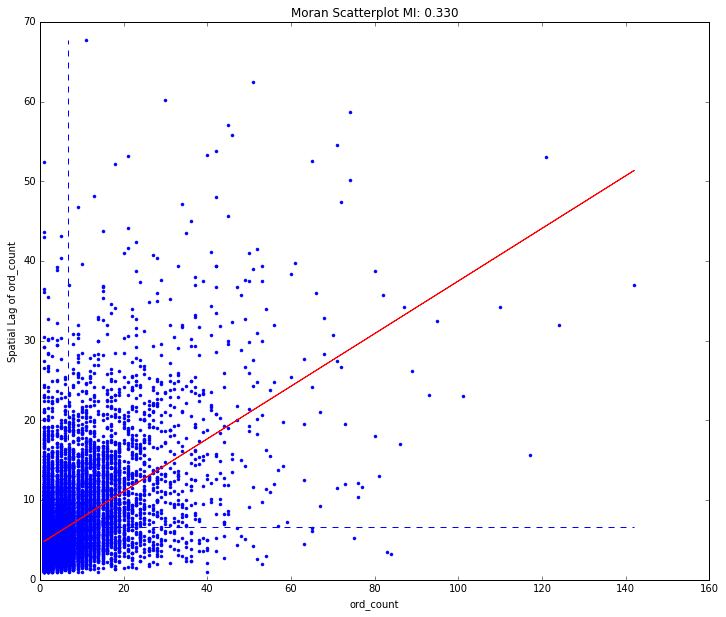

In [14]:
count = ord_count['order_nr'].values
b, a = np.polyfit(count, ylag_order_count, 1)
f, ax = plt.subplots(1, figsize=(12, 10), edgecolor='black', )
mi = esda.moran.Moran(y_order_count,queen_order_count)
plt.plot(count, ylag_order_count, '.', color='blue')
plt.vlines(count.mean(), ylag_order_count.min(), ylag_order_count.max(), linestyle='--')
plt.hlines(ylag_order_count.mean(), count.min(), count.max(), linestyle='--')
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot MI: %1.3f' % (mi.I))
plt.ylabel('Spatial Lag of ord_count')
plt.xlabel('ord_count')
plt.show()

<AxesSubplot:xlabel='order_purchase_date', ylabel='total_value'>

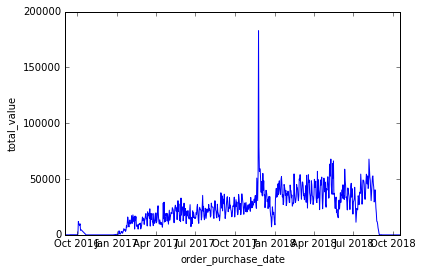

In [15]:
sns.lineplot(x="order_purchase_date",
             y="total_value", 
             data=pd.DataFrame(orders_customers_geo.groupby('order_purchase_date')['total_value'].sum()))

In [16]:
orders_gwr = orders_customers_geo[['price','seller_city','seller_state','product_width_cm','product_height_cm','product_length_cm','product_weight_g','freight_value','geolocation_lng','geolocation_lat']]
orders_gwr['freight_value'].fillna(0, inplace=True)
orders_gwr['price'].fillna(orders_gwr['price'].mean(), inplace=True)
orders_gwr['freight_value'].fillna(orders_gwr['freight_value'].mean(), inplace=True)
orders_gwr['product_width_cm'].fillna(orders_gwr['product_width_cm'].mean(), inplace=True)
orders_gwr['product_length_cm'].fillna(orders_gwr['product_length_cm'].mean(), inplace=True)
orders_gwr['product_weight_g'].fillna(orders_gwr['product_weight_g'].mean(), inplace=True)
orders_gwr['product_height_cm'].fillna(orders_gwr['product_height_cm'].mean(), inplace=True)
orders_gwr['seller_city'].fillna('EMPTY', inplace=True)
orders_gwr['seller_state'].fillna('EMPTY', inplace=True)


dummies_seller_state = pd.get_dummies(orders_gwr['seller_state']).rename(columns=lambda x: 'seller_state_' + str(x))
dummies_seller_city = pd.get_dummies(orders_gwr['seller_city']).rename(columns=lambda x: 'seller_city_' + str(x))

#orders_gwr = pd.concat([orders_gwr, dummies_product_category_name], axis=1)
orders_gwr = pd.concat([orders_gwr, dummies_seller_state], axis=1)
#orders_gwr = pd.concat([orders_gwr, dummies_seller_city], axis=1)
orders_gwr.drop(['seller_state','seller_city'], inplace=True, axis=1)

orders_gwr.columns.tolist()

['price',
 'product_width_cm',
 'product_height_cm',
 'product_length_cm',
 'product_weight_g',
 'freight_value',
 'geolocation_lng',
 'geolocation_lat',
 'seller_state_AC',
 'seller_state_AM',
 'seller_state_BA',
 'seller_state_CE',
 'seller_state_DF',
 'seller_state_EMPTY',
 'seller_state_ES',
 'seller_state_GO',
 'seller_state_MA',
 'seller_state_MG',
 'seller_state_MS',
 'seller_state_MT',
 'seller_state_PA',
 'seller_state_PB',
 'seller_state_PE',
 'seller_state_PI',
 'seller_state_PR',
 'seller_state_RJ',
 'seller_state_RN',
 'seller_state_RO',
 'seller_state_RS',
 'seller_state_SC',
 'seller_state_SE',
 'seller_state_SP']

In [17]:
orders_gwr = pd.DataFrame(orders_gwr.groupby(['geolocation_lng','geolocation_lat'])['price',
                                                                                    'product_width_cm',
                                                                                    'product_height_cm',
                                                                                    'product_length_cm',
                                                                                    'product_weight_g',
                                                                                    'freight_value'].median()).reset_index()
orders_gwr = gpd.GeoDataFrame(orders_gwr, crs=4674 , geometry=gpd.points_from_xy(orders_gwr.geolocation_lng,orders_gwr.geolocation_lat))
y = pd.DataFrame(orders_gwr['freight_value'].values.reshape((-1,1)))
X = pd.DataFrame(orders_gwr[['price','product_width_cm','product_height_cm','product_length_cm','product_weight_g']])
x_coord = orders_gwr['geolocation_lng']
y_coord = orders_gwr['geolocation_lat']
coords = pd.DataFrame(list(zip(x_coord,y_coord)))
split = round(X.shape[0] * 0.70)

orders_sar_train = orders_gwr.iloc[:split,]
y_train = y.iloc[:split,]
X_train = X.iloc[:split,]
coords_train = coords.iloc[:split,]

orders_sar_test = orders_gwr.iloc[split:,]
y_test = y.iloc[split:,]
X_test = X.iloc[split:,]
coords_test = coords.iloc[split:,]

w = sal.weights.Queen.from_dataframe(orders_sar_train)
w.transform = 'R'
#model_sar = pysal.model.spreg.OLS(y_train.values, X_train.values, w=w, nonspat_diag=False, moran=True, white_test=True, name_x=X_train.columns.tolist(), name_y='freight_value', name_w='Queen')
model_lag = pysal.model.spreg.ML_Lag(y_train.values, X_train.values, w=w,   name_x=X_train.columns.tolist(), name_y='freight_value', name_w='Queen')
#mi = pysal.explore.esda.Moran(model_sar.u, w, two_tailed=False)
#print(model_sar.summary)
#print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm]))

mi = pysal.explore.esda.Moran(model_lag.u, w, two_tailed=False)
print(model_lag.summary)
print(pd.Series(index=['Morans I','Z-Score','P-Value'],data=[mi.I, mi.z_norm, mi.p_norm]))

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :freight_value                Number of Observations:       10399
Mean dependent var  :     17.4622                Number of Variables   :           7
S.D. dependent var  :     10.0506                Degrees of Freedom    :       10392
Pseudo R-squared    :      0.5389
Spatial Pseudo R-squared:  0.3348
Sigma-square ML     :      46.859                Log likelihood        :  -35110.034
S.E of regression   :       6.845                Akaike info criterion :   70234.069
                                                 Schwarz criterion     :   70284.815

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [18]:
%%time
n_proc = 8 #Eight processors
pool = mp.Pool(n_proc) 

gwr_selector = pysal.model.mgwr.sel_bw.Sel_BW(coords_train, y_train.values, X_train.values)
gwr_bw = gwr_selector.search(pool=pool)
print("== GWR =====================")
print(gwr_bw)
print("============================")
GWR_model = pysal.model.mgwr.gwr.GWR(coords_train, y_train.values, X_train.values, gwr_bw, spherical=True).fit(pool=pool)
scale = GWR_model.scale
residuals = GWR_model.resid_response
print(GWR_model.summary())
print("============================")

pool.close() 
pool.join()

== GWR =====================
78.0


NameError: name 'GWR_model_results' is not defined

In [19]:
pred_results = GWR_model.model.predict(coords_test.values, np.array(X_test, dtype='float32'), scale, residuals)
print(pred_results.predictions)
print(y_test.values)

[[17.16731624]
 [20.75836349]
 [16.83664664]
 ...
 [35.91373864]
 [57.72610031]
 [29.74106734]]
[[15.11]
 [12.28]
 [17.19]
 ...
 [36.86]
 [66.21]
 [22.85]]
